In [128]:
# imports:
from sklearnex import patch_sklearn
patch_sklearn()


import numpy as np
import pandas as pd
import os
import sklearn
import csv
import pickle
import time
import matplotlib.pyplot as plt

%matplotlib notebook

from tsfresh import extract_features
from tsfresh import extract_relevant_features
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold 
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, StratifiedGroupKFold, cross_validate
from sklearn.model_selection import learning_curve
from sklearn.compose import make_column_transformer

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
filename= os.path.join('train', 'train_0.csv')
df0 = pd.read_csv(filename, index_col=0)
df0['time'] = df0.index
df0['index'] = 0
filename= os.path.join('train', 'train_1.csv')
df1 = pd.read_csv(filename, index_col=0)
df1['time'] = df1.index
df1['index'] = 1
df0 = pd.concat([df0,df1])
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4000 non-null   float64
 1   1       4000 non-null   float64
 2   2       4000 non-null   float64
 3   time    4000 non-null   int64  
 4   index   4000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 187.5 KB


In [4]:
DATAPATH = 'train'
DATASET = 'train_'

df = pd.DataFrame(dtype=float)
for i in range(1100):
    filename= os.path.join(DATAPATH, DATASET +str(i)+ '.csv')
    df_ = pd.read_csv(filename, index_col=0)
    df_['time'] = df_.index
    df_['index'] = i
    df = pd.concat([df, df_])

In [5]:
df.head()

,0,1,2,time,index
0,-0.027045,-0.24203,-0.000345,0,0
1,-0.026528,-0.23747,-0.000084,1,0
2,-0.026161,-0.23259,-0.000192,2,0
3,-0.025600,-0.22748,-0.000297,3,0
4,-0.024944,-0.22217,-0.000379,4,0


<IPython.core.display.Javascript object>


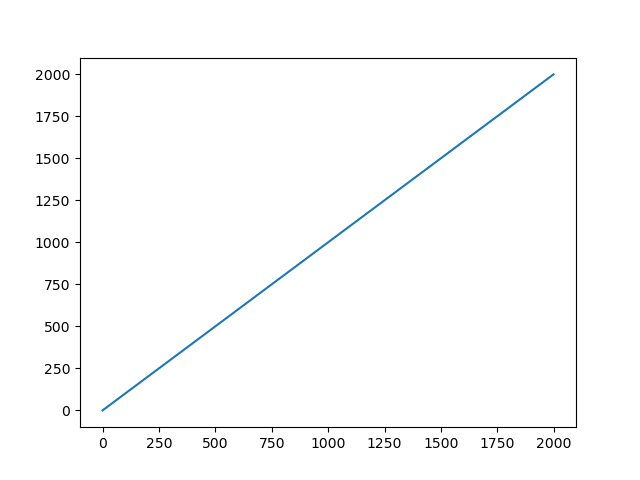

<AxesSubplot:>

In [6]:
df['time'].plot()

In [7]:
#extracted_features = extract_features(df, column_id="index", column_sort="time",n_jobs=0)
extracted_features =  pd.read_csv('raw_data.csv', index_col=0)

In [8]:
#extracted_features.to_csv('raw_data.csv', index=False)

In [113]:
extracted_features.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1100 entries, 0.0 to 0.0
Columns: 2366 entries, 0__has_duplicate_max to 2__mean_n_absolute_max__number_of_maxima_7
dtypes: float64(2366)
memory usage: 19.9 MB


In [175]:
data = extracted_features.dropna(axis=1)


In [176]:
data.head()

,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,0__mean,...,2__permutation_entropy__dimension_5__tau_1,2__permutation_entropy__dimension_6__tau_1,2__permutation_entropy__dimension_7__tau_1,"2__matrix_profile__feature_""min""__threshold_0.98","2__matrix_profile__feature_""max""__threshold_0.98","2__matrix_profile__feature_""mean""__threshold_0.98","2__matrix_profile__feature_""median""__threshold_0.98","2__matrix_profile__feature_""25""__threshold_0.98","2__matrix_profile__feature_""75""__threshold_0.98",2__mean_n_absolute_max__number_of_maxima_7
0__variance_larger_than_standard_deviation,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,1.0,-0.442275,0.851536,0.000479,0.000001,-2.294795e-07,0.000005,-0.000221,...,4.692189,6.233202,7.261476,0.984912,2.700453,1.828989,1.844765,1.693710,1.993897,0.000443
0.0,0.0,0.0,1.0,-0.766685,0.780623,0.000451,0.000010,-1.414164e-07,-0.000111,-0.000383,...,4.661746,6.222380,7.232477,0.807981,2.529134,1.781263,1.799463,1.594749,1.976426,0.000655
0.0,0.0,0.0,1.0,-0.523175,0.865784,0.000480,0.000006,-1.799299e-07,0.000007,-0.000262,...,4.684714,6.256297,7.296334,0.653066,2.346886,1.407556,1.416203,1.258539,1.564722,0.000430
0.0,0.0,0.0,1.0,-1.608302,0.820806,0.000448,0.000015,-9.759760e-08,-0.000793,-0.000804,...,4.677766,6.252514,7.300641,0.722925,2.715467,1.790795,1.802346,1.640931,1.976026,0.000596
0.0,0.0,0.0,1.0,-0.869434,0.782558,0.000446,0.000012,-1.245245e-07,-0.000066,-0.000435,...,4.655679,6.226455,7.271660,0.790224,2.489511,1.782093,1.798856,1.619191,1.962498,0.000634


<IPython.core.display.Javascript object>


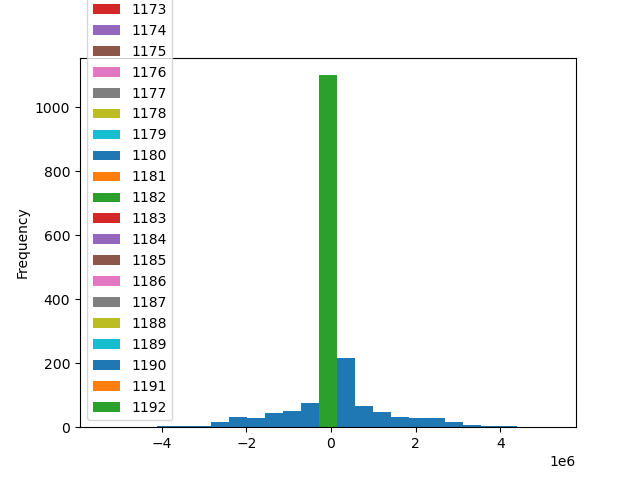

<AxesSubplot:ylabel='Frequency'>

In [12]:
data.plot.hist(bins=25)

In [120]:
df_meta = pd.read_csv("train_meta.csv")
y = df_meta["label"]
groups = []
for i in range(len(y)):
    groups.append(df_meta.loc[i]["direction"]+str(df_meta.loc[i]["label"])+str(df_meta.loc[i]["speed"])) #
groups = pd.DataFrame(groups)
#groups = df_meta["group"]
y = y.to_numpy()

In [121]:
print(groups)
df_meta.head()

             0
0     V-0.2425
1      H0.0750
2      V0.0425
3     V-0.3750
4     H-0.3750
...        ...
1095   V0.0425
1096  H-0.4425
1097   H0.0750
1098   V0.5425
1099   V0.5750

[1100 rows x 1 columns]


,id,direction,group,label,speed
0,0,V,DAQ_8,-0.2,425
1,1,H,DAQ_1,0.0,750
2,2,V,DAQ_1,0.0,425
3,3,V,DAQ_9,-0.3,750
4,4,H,DAQ_9,-0.3,750


In [165]:
n_folds =  15# Max 15 folds
cv = KFold(n_splits=n_folds, shuffle=True,random_state=1000)

In [177]:
preprocessing = Pipeline([
                        ('VT1', VarianceThreshold(threshold=0)),
                        ('QT', QuantileTransformer()),
                        ('VT2', VarianceThreshold(threshold=0))
                         ])  

#  Feature selection, you can also try others
feature_selection = Pipeline([('selectkbest', SelectKBest())])  

classifier = Pipeline([('clf', Ridge())])

pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

# You may need to specify other hyperparameters here if you investigate other blocks
k_grid = [162]
alpha_grid = [0.3]

# And make sure to add them to your param_grid

param_grid = {
    'feature_selection__selectkbest__k' : k_grid,
    'classifier__clf__alpha' : alpha_grid
}

# define GridSearchCV object

gridsearch = GridSearchCV(pipe, param_grid, n_jobs=4, cv=cv, verbose=3, 
                          return_train_score=True,scoring='neg_mean_absolute_error')

# Train the pipeline

gridsearch.fit(data,y)

Fitting 15 folds for each of 1 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=15, random_state=1000, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('VT1',
                                                         VarianceThreshold(threshold=0)),
                                                        ('QT',
                                                         QuantileTransformer()),
                                                        ('VT2',
                                                         VarianceThreshold(threshold=0))])),
                                       ('feature_selection',
                                        Pipeline(steps=[('selectkbest',
                                                         SelectKBest())])),
                                       ('classifier',
                                        Pipeline(steps=[('clf', Ridge())]))]),
             n_jobs=4,
             param_grid={'classifier__clf__alpha': [0.

In [178]:
results = gridsearch.cv_results_
train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print('Average training accuracy across folds: {:.3}'.format(train_score))
print('Average validation accuracy across folds: {:.3}'.format(validation_score))

print(gridsearch.best_params_)

Average training accuracy across folds: -0.169
Average validation accuracy across folds: -0.184
{'classifier__clf__alpha': 0.3, 'feature_selection__selectkbest__k': 162}


In [179]:
with open('ridge_0.3_162','wb') as file:
    pickle.dump(gridsearch, file)